In [5]:
print(os.getcwd())

/home/spn1560/hiec/notebooks


In [1]:
from src.mf import negative_sample_bipartite
import pickle
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from src.utils import construct_sparse_adj_mat
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import os
from collections import defaultdict

matplotlib.rcParams.update({'font.size': 14})

In [2]:
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

def construct_sparse_adj_mat(ds_name):
        '''
        Returns sparse representation of sample x feature adjacency matrix
        and lookup of sample names from row idx key.

        Args
            - ds_name: Str name of dataset

        Returns
            -
        '''      
        # Load from dataset "table of contents csv"
        df = pd.read_csv(f"data/{ds_name}/{ds_name}.csv", delimiter='\t')
        df.set_index('Entry', inplace=True)
        sample_idx = {}
        feature_idx = {}
        
        # Construct ground truth protein-function matrix
        print(f"Constructing {ds_name} sparse adjacency matrix")
        row, col, data = [], [], [] # For csr
        for i, elt in enumerate(df.index):
            labels = df.loc[elt, 'Label'].split(';')
            sample_idx[elt] = i
            for label in labels:
                if label in feature_idx:
                    j = feature_idx[label]
                else:
                    j = len(feature_idx)
                    feature_idx[label] = j
                row.append(i)
                col.append(j)
                data.append(1)
                
            print(f"{i}", end='\r')

        adj = sp.sparse.csr_matrix((data, (row, col)), shape=(len(sample_idx), len(feature_idx)))
        idx_sample = {v:k for k,v in sample_idx.items()}
        idx_feature = {v:k for k,v in feature_idx.items()}
            
        return adj, idx_sample, idx_feature

# examine grid search

In [7]:
gs_res_dir = "artifacts/model_evals/mf"
gs_name = "mf_sp_ops_esm_pt_best_5fold"

gs_res = pd.read_csv(f"{gs_res_dir}/{gs_name}_gs_res.csv", sep='\t')
show_cols = [
    "mean_val_loss",
    "std_val_loss",
      "batch_size",
      "lr",
      "user_embeds",
      # "module__n_factors",
      "module__scl_embeds", "optimizer__weight_decay", "max_epochs", "mean_fit_time", "seed"]
gs_res.loc[:, show_cols].head(20)

,mean_val_loss,std_val_loss,batch_size,lr,user_embeds,module__scl_embeds,optimizer__weight_decay,max_epochs,mean_fit_time,seed
0,0.478184,0.010537,5,0.005,esm_rank_50,True,0.00005,7500,35427.809118,1234
1,0.482670,0.012165,5,0.005,esm_rank_20,True,0.00005,7500,24719.075127,1234


In [8]:
gs_res.columns

Index(['hp_idx', 'mean_train_loss', 'std_train_loss', 'mean_val_loss',
       'std_val_loss', 'mean_fit_time', 'train_loss_curve', 'val_loss_curve',
       'seed', 'lr', 'max_epochs', 'batch_size', 'optimizer__weight_decay',
       'module__n_factors', 'module__scl_embeds'],
      dtype='object')

# examine trained models

In [2]:
train_seed = 1234
test_seed = 5678 # Must be different so that I sample diff negatives than in training
rng = np.random.default_rng(seed=train_seed)

dataset_name = 'sp_ops'

ratings, idx_sample, idx_feature = construct_sparse_adj_mat(dataset_name)
obs_pairs = list(zip(*ratings.nonzero()))
n_users, n_items = ratings.shape

# Split observed positives
X_train, X_test, y_train, y_test = train_test_split(obs_pairs, np.ones(shape=(len(obs_pairs), 1)),
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    random_state=train_seed)

X_train, X_test = np.array(X_train), np.array(X_test)

n_unobs = 500
unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs, seed=test_seed) # Use test seed for neg sampling
X_neg = np.array(unobs_pairs)

Constructing sp_ops sparse adjacency matrix


In [4]:
fn = "240429_12_21_45_fit_model_sp_ops_neg_multiple_1_seed_1234.pkl"

with open(f"/projects/p30041/spn1560/hiec/artifacts/trained_models/mf/{fn}", 'rb') as f:
        model = pickle.load(f)

In [5]:
model.get_params()

{'module': src.mf.MatrixFactorization,
 'criterion': BCELoss(),
 'optimizer': torch.optim.sgd.SGD,
 'lr': 0.005,
 'max_epochs': 5000,
 'batch_size': 10,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': skorch.dataset.Dataset,
 'train_split': functools.partial(<function _make_split at 0x2ba8a8e184a0>, valid_ds=<skorch.dataset.Dataset object at 0x2ba8aad8ae90>),
 'callbacks': None,
 'predict_nonlinearity': 'auto',
 'warm_start': False,
 'verbose': 1,
 'device': device(type='cpu'),
 'compile': False,
 'use_caching': 'auto',
 '_params_to_validate': {'module__n_factors',
  'module__n_items',
  'module__n_users',
  'module__scl_embeds',
  'optimizer__weight_decay'},
 'classes': None,
 'module__n_users': 3660,
 'module__n_items': 2271,
 'module__n_factors': 20,
 'module__scl_embeds': False,
 'optimizer__weight_decay': 0.0001,
 'callbacks__epoch_timer': <skorch.callbacks.logging.EpochTimer at 0x2ba8a8ef6a10>,
 'ca

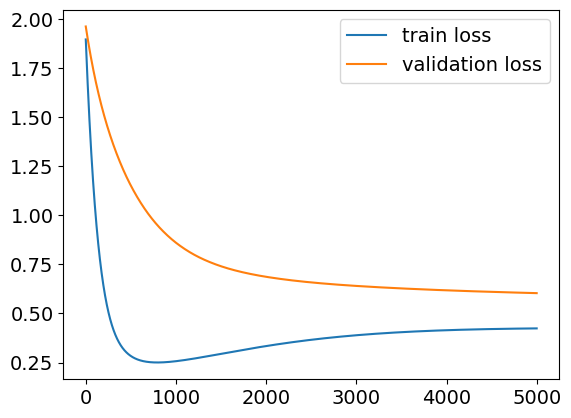

In [23]:
ds=1
tr_loss, val_loss = list(zip(*model.history[:, ('train_loss', 'valid_loss')]))
tr_loss, val_loss = np.array(tr_loss)[::ds], np.array(val_loss)[::ds]
plt.plot(tr_loss, label="train loss")
plt.plot(val_loss, label="validation loss")
plt.legend()
plt.show()

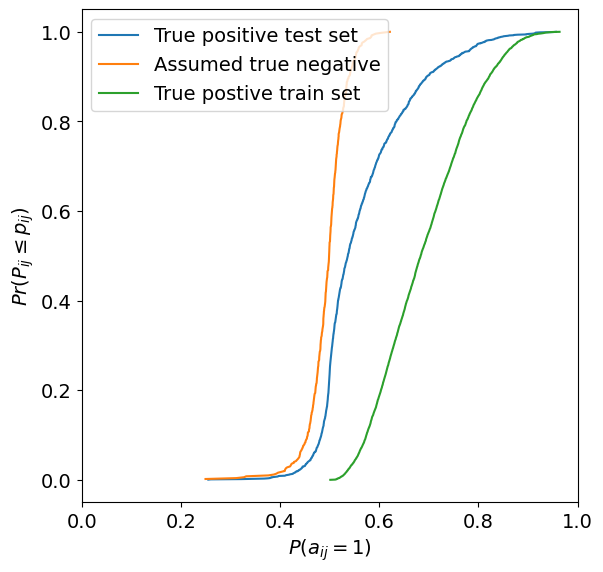

In [6]:
inputs = [X_test, X_neg, X_train]
labels = ["True positive test set", "Assumed true negative", "True postive train set"]
datas = [model.predict_proba(elt).reshape(-1, 2)[:,1] for elt in inputs]

ax = plt.figure(figsize=(6.4, 6.4))

for i in range(len(datas)):
    data = datas[i].reshape(-1, )
    xcdf = sorted(data)
    ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
    plt.plot(xcdf, ycdf, label=labels[i])

plt.xlim(0,1)
plt.legend()
plt.xlabel(r"$P(a_{ij} = 1)$")
plt.ylabel(r"$Pr(P_{ij} \leq p_{ij})$")
plt.show()

In [1]:
from src.utils import construct_sparse_adj_mat

In [2]:
dataset_name = 'sp_ops'

ratings, idx_sample, idx_feature = construct_sparse_adj_mat(dataset_name)
obs_pairs = list(zip(*ratings.nonzero()))
n_users, n_items = ratings.shape

# Split observed positives
X_train, X_test, y_train, y_test = train_test_split(obs_pairs, np.ones(shape=(len(obs_pairs), 1)),
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    random_state=seed)

Constructing sp_ops sparse adjacency matrix


NameError: name 'train_test_split' is not defined

In [3]:
ratings.shape

(3660, 2271)

In [13]:
# Calculate accuracy

scorers = {
    'f1': f1_score,
    'precision': precision_score,
    'recall': recall_score,
    'accuracy': accuracy_score
}

scores = {}

pos_pred = model.predict(X_test)
neg_pred = model.predict(X_neg)
y_pred = np.vstack((pos_pred, neg_pred)).reshape(-1,)
y_true = np.vstack((np.ones(shape=(pos_pred.shape)), np.zeros(shape=(neg_pred.shape)))).reshape(-1,)

for k, scorer in scorers.items():
    scores[k] = scorer(y_true, y_pred)

print(scores)

{'f1': 0.8023327194597913, 'precision': 0.8476005188067445, 'recall': 0.7616550116550117, 'accuracy': 0.7093862815884476}


# plot evaluation for kfold cv models

In [2]:
dataset_name = 'sp_ops'
n_splits = 5
train_seed = 1234
test_seed = 5678

rng = np.random.default_rng(seed=train_seed)

# Load data
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset_name)
X = np.array(list(zip(*adj.nonzero())))
n_users, n_items = adj.shape

# Split data
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=train_seed)

X_trains, y_trains, X_tests, y_tests = [], [], [], []
X_neg_tests, y_neg_tests = [], []
for i, (train_idx, test_idx) in enumerate(kfold.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = np.ones(shape=(X_train.shape[0],)), np.ones(shape=(X_test.shape[0],))
    X_neg_test = negative_sample_bipartite(X_test.shape[0], n_users, n_items, X, seed=test_seed) # Sample test negatives
    y_neg_test = np.zeros(shape=(X_test.shape[0]))

    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)
    X_neg_tests.append(X_neg_test)
    y_neg_tests.append(y_neg_test)

Constructing sp_ops sparse adjacency matrix


In [8]:
import re
def extract_number(text, substring):
    pattern = re.compile(rf'{re.escape(substring)}_(\d+)')
    match = pattern.search(text)
    if match:
        return int(match.group(1))
    else:
        return None
    

def extract_substring_between(text, substring_a, substring_b):
    pattern = re.compile(rf'{re.escape(substring_a)}(.*?){re.escape(substring_b)}')
    match = pattern.search(text)
    if match:
        return match.group(1)
    else:
        return None
    
extract_number('240506_07_07_20_model_mf_sp_ops_esm_pt_best_5fold_sp_ops_seed_1234_5fold_cv__hp_idx_1_split_idx_4', 'seed')
extract_substring_between('240506_07_07_20_model_mf_sp_ops_esm_pt_best_5fold_sp_ops_seed_1234_5fold_cv__hp_idx_1_split_idx_4', "model_", f"_{dataset_name}_seed")

NameError: name 'dataset_name' is not defined

In [10]:
model_dir = '/projects/p30041/spn1560/hiec/artifacts/trained_models/mf'
gs_names = ['mf_sp_ops_best_5fold', 'mf_sp_ops_esm_pt_best_5fold']
n_hps = {k:3 for k in gs_names}

hp_labels = {
    'mf_sp_ops_best_5fold': [None for i in range(3)],
    'mf_sp_ops_esm_pt_best_5fold':[None for i in range(3)]
}

hpois = {
    'mf_sp_ops_best_5fold': 'module__n_factors',
    'mf_sp_ops_esm_pt_best_5fold': 'module__user_embeds'
}

scorers = {
    'f1': f1_score,
    'precision': precision_score,
    'recall': recall_score,
    'accuracy': accuracy_score
}

scores = {}
probas = {}

fns = []
for name in gs_names:
    scores[name] = {}
    probas[name] = {}
    for hp_idx in range(n_hps[name]):
        proba_X_train, proba_X_test, proba_neg_X_test = [], [], []
        hp_scores = defaultdict(list)
        
        for split_idx in range(n_splits):
            stem = f"_model_{name}_{dataset_name}_seed_{train_seed}_{n_splits}fold_cv__hp_idx_{hp_idx}_split_idx_{split_idx}.pkl"
            for fn in os.listdir(model_dir):
                if stem in fn:
                    with open(f"{model_dir}/{fn}", 'rb') as f:
                        model = pickle.load(f)

                    hp_label = model.get_params()[hpois[name]] # Get label
                    if type(hp_label) == np.ndarray:
                        hp_label = hp_label.shape[1]
                    
                    # hp_labels[name][hp_idx] = label

        
                    # Predict proba on train pos, test pos, test neg
                    proba_X_train.append(model.predict_proba(X_trains[split_idx]).reshape(-1, 2)[:,1].reshape(-1,))
                    proba_X_test.append(model.predict_proba(X_tests[split_idx]).reshape(-1, 2)[:,1].reshape(-1,))
                    proba_neg_X_test.append(model.predict_proba(X_neg_tests[split_idx]).reshape(-1, 2)[:,1].reshape(-1,))

                    # Predict on train pos, test pos, test neg
                    pos_pred = model.predict(X_tests[split_idx])
                    neg_pred = model.predict(X_neg_tests[split_idx])
                    y_pred = np.vstack((pos_pred, neg_pred)).reshape(-1,)
                    y_true = np.vstack((y_tests[split_idx], y_neg_tests[split_idx])).reshape(-1,)

                    for k, scorer in scorers.items():
                        hp_scores[k].append(scorer(y_true, y_pred))


        # Aggregate splits
        proba_X_train = np.hstack(proba_X_train)
        proba_X_test = np.hstack(proba_X_test)
        proba_neg_X_test = np.hstack(proba_neg_X_test)
        probas[name][hp_label] = (proba_X_train, proba_X_test, proba_neg_X_test)

        scores[name][hp_label] = {}
        for k,v in hp_scores.items():
            mu, sig = np.array(v).mean(), np.std(np.array(v))
            scores[name][hp_label][k] = (mu, sig)


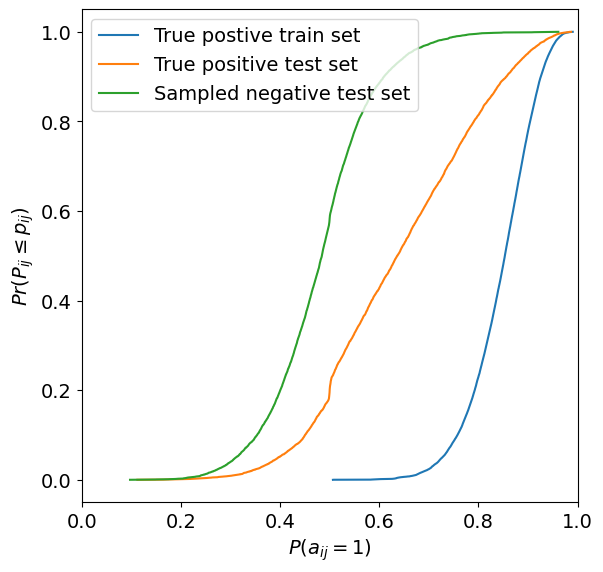

In [19]:
# Plot cdfs

name = gs_names[1]
hp_label = 50

labels = ["True postive train set", "True positive test set", "Sampled negative test set", ]
datas = [elt for elt in probas[name][hp_label]]

ax = plt.figure(figsize=(6.4, 6.4))

for i in range(len(datas)):
    data = datas[i].reshape(-1, )
    xcdf = sorted(data)
    ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
    plt.plot(xcdf, ycdf, label=labels[i])

plt.xlim(0,1)
plt.legend()
plt.xlabel(r"$P(a_{ij} = 1)$")
plt.ylabel(r"$Pr(P_{ij} \leq p_{ij})$")
plt.show()

In [17]:
scores

{'mf_sp_ops_best_5fold': {20: {'f1': (0.6847091631618305,
    0.008615799902255817),
   'precision': (0.6127557236447755, 0.008485831662506523),
   'recall': (0.7758464664587114, 0.009916616831278922),
   'accuracy': (0.6427300590565898, 0.010275871316712806)},
  50: {'f1': (0.6952541222613626, 0.009618611494302338),
   'precision': (0.6180196232110101, 0.007159000531555529),
   'recall': (0.7946136176748422, 0.014780237579099742),
   'accuracy': (0.6517650037037791, 0.009792016093562533)},
  100: {'f1': (0.7042251943430664, 0.004973864896256377),
   'precision': (0.6231852882059423, 0.005708455550178242),
   'recall': (0.8095352266780838, 0.00619486484270715),
   'accuracy': (0.659982976207466, 0.006454005740215392)}},
 'mf_sp_ops_esm_pt_best_5fold': {20: {'f1': (0.7102580167959334,
    0.00929366904073963),
   'precision': (0.6484195166978696, 0.00721113022201321),
   'recall': (0.7851722427232631, 0.013048276120110615),
   'accuracy': (0.6797408713735245, 0.009431982876027502)},
  5

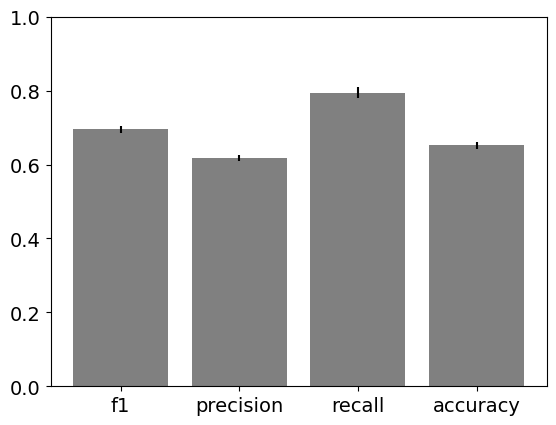

In [61]:
# Plot single hp set perf

name = gs_names[0]
hp_label = 50
data = scores[name][hp_label]
x = list(data.keys())
mu, sig = list(zip(*data.values()))

plt.bar(x, mu, yerr=sig, color='gray')
plt.ylim(0,1)
plt.show()


In [ ]:
# Plot esm vs full at d

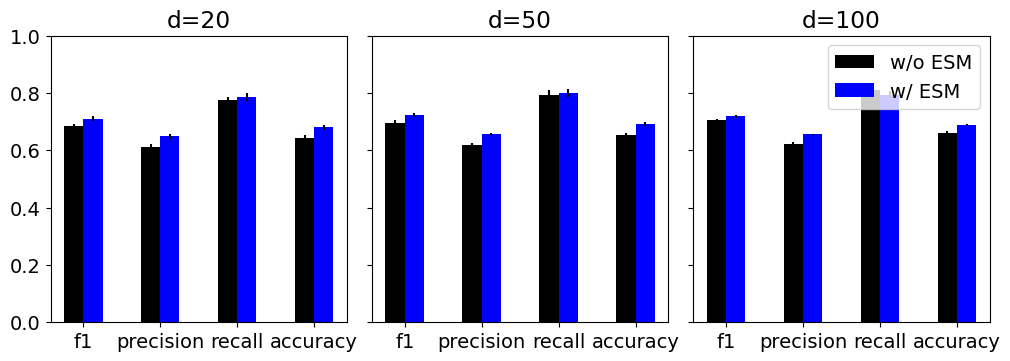

In [59]:
# Plot esm vs full at all ds tried

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

metrics = list(scorers.keys())
ds = [20, 50, 100]
conditions = ["w/o ESM", "w/ ESM"]
colors = ['black', 'blue']

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(10,3.5), constrained_layout=True)

for i, d  in enumerate(ds):
    for j, name in enumerate(scores.keys()):
        data = scores[name][d]
        # x = list(data.keys())
        mu, sig = list(zip(*data.values()))
        offset = width * (j - 0.5)
        rects = ax[i].bar(x + offset, mu, yerr=sig, width=width, label=conditions[j], color=colors[j])
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(metrics)
        ax[i].set_title(f"d={d}")
   


ax[-1].legend(loc='upper right')
ax[0].set_ylim(0,1)


plt.show()

In [29]:
x

['f1', 'precision', 'recall', 'accuracy']